## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix

In [3]:
import hw

## Load data

In [4]:
cropped_data_dir = 'data/CroppedYale/'
cropped = hw.LoadCropped(cropped_data_dir)

In [5]:
X             = cropped.X
y             = cropped.y
h             = cropped.h
w             = cropped.w
target_names  = cropped.target_names
n_samples     = cropped.n_samples
n_features    = cropped.n_features
n_classes     = cropped.n_classes

## Split into training and test data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)

## Compute rank r truncation

In [7]:
U,S,VT = np.linalg.svd(X_train.T,full_matrices=0) 

In [8]:
var_explained = np.round(S**2/np.sum(S**2), decimals=100)
thresh = 0.99
cdf=np.cumsum(var_explained)
n_components = np.where(cdf>thresh)[0][0]
n_components

136

## Compute eigenfaces and project images into subspace

In [9]:
pca = PCA(n_components=n_components, 
          svd_solver='randomized',
          whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

## Support Vector Classification

In [10]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

model = SVC(kernel='rbf', class_weight='balanced')

## Cross-Validation

In [11]:
clf = GridSearchCV(model, param_grid)
clf = clf.fit(X_train_pca, y_train)

In [12]:
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Score: %0.2f" % clf.best_score_)

Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Score: 0.94


## Predict

In [13]:
y_pred = clf.predict(X_test_pca)
# print(classification_report(y_test, y_pred, target_names=target_names))
# print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

In [14]:
! mkdir plots/individual

mkdir: plots/individual: File exists


## Plot confusion matrix

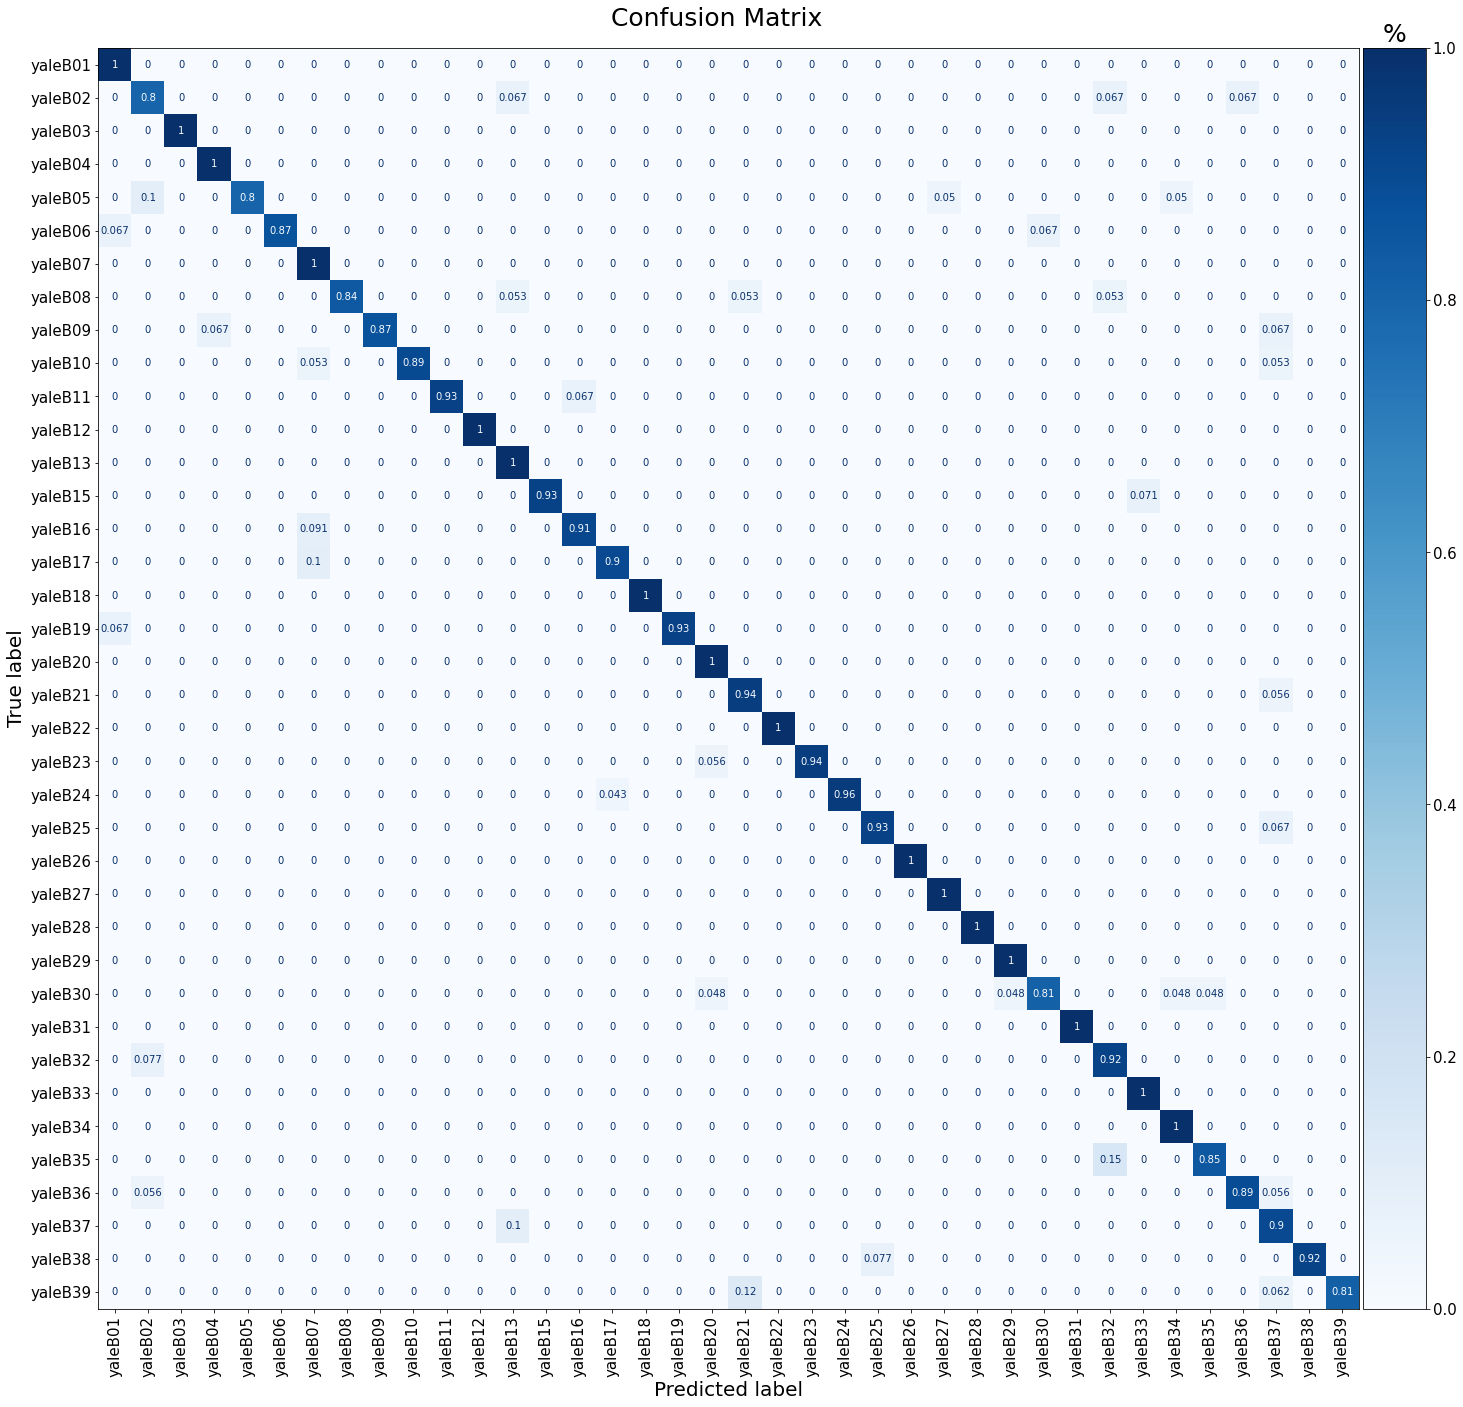

In [15]:
fig,ax = plt.subplots(figsize=(20,20))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

plt.savefig('plots/individual/svc_individuals_confusion_matrix.png');

## Plot hits and misses

In [16]:
hits = X_test[(y_pred == y_test)]
misses = X_test[(y_pred != y_test)]

In [18]:
len(misses)

39

In [19]:
len(hits)

565

In [20]:
len(misses) + len(hits)

604

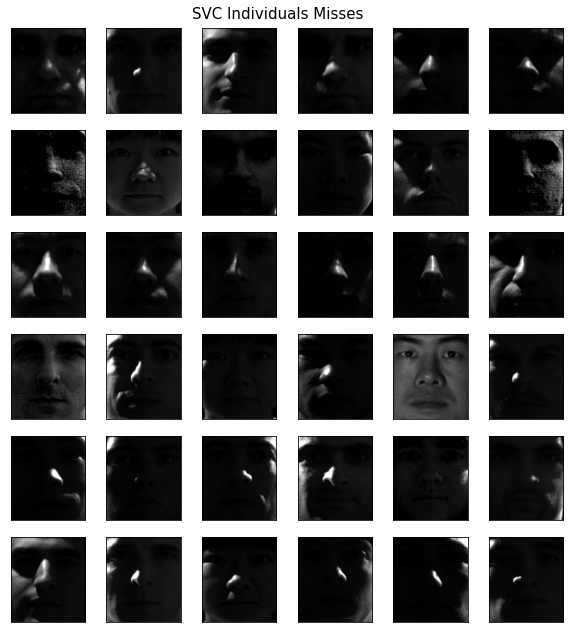

In [17]:
hw.plot_images_subset(misses,
                       rows = 6,
                       columns = 6,
                       figsize= (10,10),
                       reshape = (h,w),
                       title = "SVC Individuals Misses")

plt.savefig('plots/individual/svc_individuals_misses.png')

## References

https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html